## Практическая работа №6
##### Сиразетдинов Рустем (Вариант - 20)

Предсказание стоимости медецинской страховки

Данные: https://www.kaggle.com/mirichoi0218/insurance

In [38]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.offline import plot, iplot, init_notebook_mode
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error
import warnings
warnings.filterwarnings("ignore")
import math

# Выгрузка датасета
ins = pd.read_csv('C:\\Users\\averu\\Documents\\git_local\\programming-practice\\IDA\\IDA-practice-5\\insurance.csv')
print("There are {:,} observations and {} columns in the data set.".format(ins.shape[0], ins.shape[1]))
print("There are {} missing values in the data.".format(ins.isna().sum().sum()))


ins['sex'] = ins['sex'].str.capitalize()
ins['smoker'] = ins['smoker'].apply(lambda x: 'Smoker' if x=='yes' else 'Non-Smoker')
ins['region'] = ins['region'].str.capitalize()

There are 1,338 observations and 7 columns in the data set.
There are 0 missing values in the data.


In [39]:
init_notebook_mode(connected=True)
px.defaults.template = "plotly_white"
plot_df=ins.copy()
fig = px.box(plot_df, x="region", y="charges", color="region", 
             notched=True, points="outliers", height=600,
             title="",
             color_discrete_sequence=['#B14B51', '#D0A99C', '#5D8370', '#6C839B'])
fig.update_traces(marker=dict(size=9, opacity=0.5, line=dict(width=1,color="#F7F7F7")), showlegend=False)
fig.update_layout(font_color="#303030", xaxis_title='Region', yaxis_title='Claim Amount, $',
                  yaxis=dict(showgrid=True, gridwidth=1, gridcolor='#EAEAEA', zerolinecolor='#EAEAEA'))
fig.show()

Для каждого региона графики показывают, что страховые сборы положительно искажены с несколькими большими отклонениями. Страховые сборы более изменчивы в Юго-Восточном регионе, который содержит самую высокую претензию в наборе данных - более 63 000 долларов США, а также самую низкую претензию - 1121 доллар США. Северо-Восточный регион имеет самую высокую среднюю стоимость в целом, хотя, поскольку отметки в графиках накладываются друг на друга, средние суммы претензий, вероятно, существенно не отличаются.

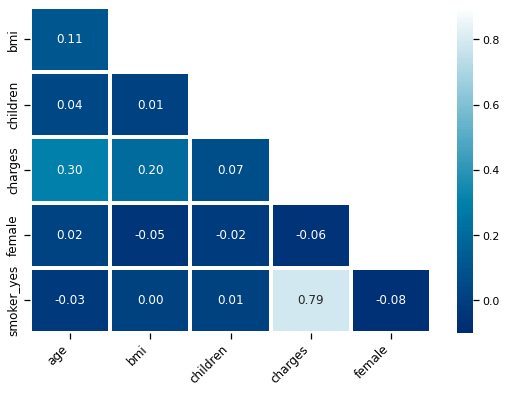

In [40]:
ins['female'] = ins['sex'].apply(lambda x: 1 if x=='Female' else 0)
ins['smoker_yes'] = ins['smoker'].apply(lambda x: 1 if x=='Smoker' else 0)
ins.drop(['sex', 'smoker'], axis=1, inplace=True)

sns.set_context("notebook")
fig, ax = plt.subplots(figsize=(9,6))   
corr=ins.corr()
mask=np.triu(np.ones_like(corr, dtype=bool))[1:, :-1]
corr=corr.iloc[1:,:-1].copy()
ax=sns.heatmap(corr, mask=mask, vmin=-.1, vmax=.9, center=0, annot=True, fmt='.2f', 
               cmap='ocean', linewidths=4, annot_kws={"fontsize":12})
ax.set_title('', fontsize=18)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right',fontsize=12)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
fig.show()

Корреляционная матрица показывает, что курильщики имеют сильную положительную связь со страховыми взносами на уровне 0,79, но в целом переменные в наборе данных не слишком сильно коррелируют друг с другом.

Построение линейной регрессии

In [41]:
data = pd.read_csv('C:\\Users\\averu\\Documents\\git_local\\programming-practice\\IDA\\IDA-practice-5\\insurance.csv')

data['sex'] = data['sex'].str.capitalize()
data['smoker'] = data['smoker'].apply(lambda x: 'Smoker' if x=='yes' else 'Non-Smoker')

data['female'] = data['sex'].apply(lambda x: 1 if x=='Female' else 0)
data['smoker_yes'] = data['smoker'].apply(lambda x: 1 if x=='Smoker' else 0)


region = pd.get_dummies(data['region']) 
data = pd.concat((data, region), axis=1)
data = data.loc[:, data.columns.isin(['age', 'female', 'bmi', 'children' , 'smoker_yes', 'charges', 'northeast', 'northwest','southeast', 'southwest'])]

data.head(7)

,age,bmi,children,charges,female,smoker_yes,northeast,northwest,southeast,southwest
0,19,27.900,0,16884.92400,1,1,0,0,0,1
1,18,33.770,1,1725.55230,0,0,0,0,1,0
2,28,33.000,3,4449.46200,0,0,0,0,1,0
3,33,22.705,0,21984.47061,0,0,0,1,0,0
4,32,28.880,0,3866.85520,0,0,0,1,0,0
5,31,25.740,0,3756.62160,1,0,0,0,1,0
6,46,33.440,1,8240.58960,1,0,0,0,1,0


Модель 1. Все признаки присутствуют.

In [42]:
y_train=data.pop('charges')
X_train = data.copy()

import statsmodels.api as sm
X_train_sm = sm.add_constant(X_train)

lm= sm.OLS(y_train, X_train_sm).fit()

lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                charges   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.749
Method:                 Least Squares   F-statistic:                     500.8
Date:                Fri, 03 Jun 2022   Prob (F-statistic):               0.00
Time:                        13:03:31   Log-Likelihood:                -13548.
No. Observations:                1338   AIC:                         2.711e+04
Df Residuals:                    1329   BIC:                         2.716e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.013e+04    791.569    -12.792      0.000   -1.17e+04   -8572.628
age          256.8564     11.899     21.587      0.000     233.514     280.199
bmi          339.1935     28.599     11.860      0.000     283.088     395.298
children     475.5005    137.804      3.451      0.001     205.163     745.838
female       131.3144    332.945      0.394      0.693    -521.842     784.470
smoker_yes  2.385e+04    413.153     57.723      0.000     2.3e+04    2.47e+04
northeast  -1944.3632    334.580     -5.811      0.000   -2600.725   -1288.001
northwest  -2297.3271    335.065     -6.856      0.000   -2954.641   -1640.014
southeast  -2979.3852    386.076     -7.717      0.000   -3736.771   -2222.000
southwest  -2904.4142    352.330     -8.243      0.000   -3595.597   -2213.231
==============================================================================
Omnibus:                      300.366   Durbin-Watson:                   2.088
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              718.887
Skew:                           1.211   Prob(JB):                    7.86e-157
Kurtosis:                       5.651   Cond. No.                     2.36e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 6.3e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

Модель 2. Квадрат признака `bmi`. 

In [43]:
# y_train=data.pop('charges')
X_train = data.copy()
for i in range(0 , len(X_train['bmi'])):
    X_train['bmi'][i] = X_train['bmi'][i] * X_train['bmi'][i]

# X_train['bmi'] = list(map(lambda x: x, X_train['bmi']))

import statsmodels.api as sm
X_train_sm = sm.add_constant(X_train)

bmi_sq= sm.OLS(y_train, X_train_sm).fit()

bmi_sq.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                charges   R-squared:                       0.749
Model:                            OLS   Adj. R-squared:                  0.748
Method:                 Least Squares   F-statistic:                     496.0
Date:                Fri, 03 Jun 2022   Prob (F-statistic):               0.00
Time:                        13:03:31   Log-Likelihood:                -13553.
No. Observations:                1338   AIC:                         2.712e+04
Df Residuals:                    1329   BIC:                         2.717e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -5883.5713    538.559    -10.925      0.000   -6940.089   -4827.053
age          258.6085     11.930     21.676      0.000     235.204     282.013
bmi            5.1537      0.452     11.405      0.000       4.267       6.040
children     475.2722    138.305      3.436      0.001     203.953     746.592
female       122.1799    334.141      0.366      0.715    -533.322     777.682
smoker_yes  2.383e+04    414.638     57.483      0.000     2.3e+04    2.46e+04
northeast   -919.4003    313.989     -2.928      0.003   -1535.368    -303.433
northwest  -1225.9668    313.839     -3.906      0.000   -1841.641    -610.293
southeast  -1917.0905    340.227     -5.635      0.000   -2584.532   -1249.649
southwest  -1821.1137    321.593     -5.663      0.000   -2451.998   -1190.229
==============================================================================
Omnibus:                      294.077   Durbin-Watson:                   2.092
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              706.585
Skew:                           1.185   Prob(JB):                    3.69e-154
Kurtosis:                       5.657   Cond. No.                     5.96e+18
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 4.16e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [44]:
# y_train=data.pop('charges')
X_train = data.copy()
for i in range(0 , len(X_train['bmi'])):
    X_train['bmi'][i] = X_train['bmi'][i] * X_train['bmi'][i] * X_train['bmi'][i]

# X_train['bmi'] = list(map(lambda x: x, X_train['bmi']))

import statsmodels.api as sm
X_train_sm = sm.add_constant(X_train)

bmi_sq= sm.OLS(y_train, X_train_sm).fit()

bmi_sq.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                charges   R-squared:                       0.746
Model:                            OLS   Adj. R-squared:                  0.745
Method:                 Least Squares   F-statistic:                     488.8
Date:                Fri, 03 Jun 2022   Prob (F-statistic):               0.00
Time:                        13:03:32   Log-Likelihood:                -13560.
No. Observations:                1338   AIC:                         2.714e+04
Df Residuals:                    1329   BIC:                         2.718e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -4413.6325    481.816     -9.160      0.000   -5358.835   -3468.430
age          260.8030     11.983     21.764      0.000     237.295     284.311
bmi            0.0966      0.009     10.683      0.000       0.079       0.114
children     475.6285    139.068      3.420      0.001     202.812     748.445
female       108.3835    335.968      0.323      0.747    -550.701     767.468
smoker_yes  2.382e+04    416.911     57.136      0.000     2.3e+04    2.46e+04
northeast   -599.2807    313.375     -1.912      0.056   -1214.044      15.483
northwest   -871.5931    313.438     -2.781      0.005   -1486.481    -256.706
southeast  -1508.7125    329.623     -4.577      0.000   -2155.351    -862.075
southwest  -1434.0462    317.310     -4.519      0.000   -2056.529    -811.564
==============================================================================
Omnibus:                      286.501   Durbin-Watson:                   2.094
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              689.952
Skew:                           1.154   Prob(JB):                    1.51e-150
Kurtosis:                       5.654   Cond. No.                     1.75e+20
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 6.2e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [45]:
# y_train=data.pop('charges')
X_train = data.copy()
for i in range(0 , len(X_train['age'])):
    X_train['age'][i] = X_train['age'][i] * X_train['age'][i] * X_train['age'][i]

# X_train['bmi'] = list(map(lambda x: x, X_train['bmi']))

import statsmodels.api as sm
X_train_sm = sm.add_constant(X_train)

bmi_sq= sm.OLS(y_train, X_train_sm).fit()

bmi_sq.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                charges   R-squared:                       0.753
Model:                            OLS   Adj. R-squared:                  0.751
Method:                 Least Squares   F-statistic:                     505.9
Date:                Fri, 03 Jun 2022   Prob (F-statistic):               0.00
Time:                        13:03:32   Log-Likelihood:                -13543.
No. Observations:                1338   AIC:                         2.710e+04
Df Residuals:                    1329   BIC:                         2.715e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -5503.6284    739.074     -7.447      0.000   -6953.507   -4053.749
age            0.0494      0.002     21.899      0.000       0.045       0.054
bmi          335.2383     28.509     11.759      0.000     279.311     391.166
children     728.8385    137.301      5.308      0.000     459.489     998.188
female       146.6043    331.672      0.442      0.659    -504.054     797.262
smoker_yes  2.385e+04    411.599     57.952      0.000     2.3e+04    2.47e+04
northeast   -778.6449    325.191     -2.394      0.017   -1416.590    -140.700
northwest  -1161.5119    326.079     -3.562      0.000   -1801.198    -521.826
southeast  -1820.4286    380.077     -4.790      0.000   -2566.045   -1074.812
southwest  -1743.0429    343.828     -5.070      0.000   -2417.547   -1068.538
==============================================================================
Omnibus:                      306.978   Durbin-Watson:                   2.099
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              758.555
Skew:                           1.223   Prob(JB):                    1.91e-165
Kurtosis:                       5.760   Cond. No.                     5.67e+20
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 5.19e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [46]:
# y_train=data.pop('charges')
X_train = data.copy()
for i in range(0 , len(X_train['age'])):
    X_train['age'][i] = pow(X_train['age'][i], 0.4)

# X_train['bmi'] = list(map(lambda x: x, X_train['bmi']))

import statsmodels.api as sm
X_train_sm = sm.add_constant(X_train)

bmi_sq= sm.OLS(y_train, X_train_sm).fit()

bmi_sq.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                charges   R-squared:                       0.733
Model:                            OLS   Adj. R-squared:                  0.731
Method:                 Least Squares   F-statistic:                     455.8
Date:                Fri, 03 Jun 2022   Prob (F-statistic):               0.00
Time:                        13:03:32   Log-Likelihood:                -13594.
No. Observations:                1338   AIC:                         2.721e+04
Df Residuals:                    1329   BIC:                         2.725e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.657e+04   1022.033    -16.210      0.000   -1.86e+04   -1.46e+04
age         4645.6706    250.168     18.570      0.000    4154.904    5136.437
bmi          349.1908     29.603     11.796      0.000     291.117     407.265
children     582.3995    142.585      4.085      0.000     302.682     862.117
female       160.4322    344.770      0.465      0.642    -515.920     836.784
smoker_yes  2.379e+04    427.807     55.620      0.000     2.3e+04    2.46e+04
northeast  -3530.9103    379.803     -9.297      0.000   -4275.989   -2785.832
northwest  -3903.5203    380.164    -10.268      0.000   -4649.308   -3157.733
southeast  -4632.7308    425.510    -10.887      0.000   -5467.475   -3797.987
southwest  -4500.2306    395.848    -11.369      0.000   -5276.785   -3723.676
==============================================================================
Omnibus:                      285.712   Durbin-Watson:                   2.070
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              665.974
Skew:                           1.165   Prob(JB):                    2.43e-145
Kurtosis:                       5.553   Cond. No.                     1.18e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 9.59e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [47]:
# y_train=data.pop('charges')
X_train = data.copy()
for i in range(0 , len(X_train['age'])):
    X_train['age'][i] = pow(X_train['age'][i], 0.8)

# X_train['bmi'] = list(map(lambda x: x, X_train['bmi']))

import statsmodels.api as sm
X_train_sm = sm.add_constant(X_train)

bmi_sq= sm.OLS(y_train, X_train_sm).fit()

bmi_sq.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                charges   R-squared:                       0.749
Model:                            OLS   Adj. R-squared:                  0.748
Method:                 Least Squares   F-statistic:                     496.8
Date:                Fri, 03 Jun 2022   Prob (F-statistic):               0.00
Time:                        13:03:33   Log-Likelihood:                -13552.
No. Observations:                1338   AIC:                         2.712e+04
Df Residuals:                    1329   BIC:                         2.717e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.162e+04    822.762    -14.121      0.000   -1.32e+04      -1e+04
age          657.8267     30.829     21.338      0.000     597.348     718.305
bmi          340.4290     28.682     11.869      0.000     284.163     396.695
children     443.4386    138.288      3.207      0.001     172.152     714.725
female       132.7205    333.940      0.397      0.691    -522.387     787.828
smoker_yes  2.387e+04    414.414     57.603      0.000    2.31e+04    2.47e+04
northeast  -2332.2410    340.401     -6.851      0.000   -3000.023   -1664.459
northwest  -2650.7961    340.333     -7.789      0.000   -3318.445   -1983.147
southeast  -3372.5650    390.595     -8.634      0.000   -4138.815   -2606.315
southwest  -3262.2291    357.419     -9.127      0.000   -3963.396   -2561.062
==============================================================================
Omnibus:                      296.714   Durbin-Watson:                   2.088
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              702.164
Skew:                           1.202   Prob(JB):                    3.37e-153
Kurtosis:                       5.611   Cond. No.                     1.82e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 5.31e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [48]:
# y_train=data.pop('charges')
X_train = data.copy()
for i in range(0 , len(X_train['age'])):
    X_train['age'][i] = pow(X_train['age'][i], 1.2)

# X_train['bmi'] = list(map(lambda x: x, X_train['bmi']))

import statsmodels.api as sm
X_train_sm = sm.add_constant(X_train)

bmi_sq= sm.OLS(y_train, X_train_sm).fit()

bmi_sq.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                charges   R-squared:                       0.752
Model:                            OLS   Adj. R-squared:                  0.750
Method:                 Least Squares   F-statistic:                     503.4
Date:                Fri, 03 Jun 2022   Prob (F-statistic):               0.00
Time:                        13:03:33   Log-Likelihood:                -13545.
No. Observations:                1338   AIC:                         2.711e+04
Df Residuals:                    1329   BIC:                         2.716e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -8916.3223    771.341    -11.560      0.000   -1.04e+04   -7403.143
age          103.8060      4.774     21.746      0.000      94.441     113.171
bmi          338.0808     28.549     11.842      0.000     282.075     394.086
children     504.9358    137.491      3.673      0.000     235.213     774.658
female       131.3019    332.307      0.395      0.693    -520.602     783.206
smoker_yes  2.385e+04    412.362     57.833      0.000     2.3e+04    2.47e+04
northeast  -1642.8805    330.953     -4.964      0.000   -2292.127    -993.634
northwest  -1996.2360    331.525     -6.021      0.000   -2646.605   -1345.867
southeast  -2676.2085    383.401     -6.980      0.000   -3428.345   -1924.072
southwest  -2600.9974    348.944     -7.454      0.000   -3285.539   -1916.456
==============================================================================
Omnibus:                      302.840   Durbin-Watson:                   2.090
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              730.609
Skew:                           1.217   Prob(JB):                    2.24e-159
Kurtosis:                       5.679   Cond. No.                     5.66e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.69e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [49]:
# y_train=data.pop('charges')
X_train = data.copy()
for i in range(0 , len(X_train['age'])):
    X_train['age'][i] = pow(X_train['age'][i], 1.6)

# X_train['bmi'] = list(map(lambda x: x, X_train['bmi']))

import statsmodels.api as sm
X_train_sm = sm.add_constant(X_train)

bmi_sq= sm.OLS(y_train, X_train_sm).fit()

bmi_sq.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                charges   R-squared:                       0.753
Model:                            OLS   Adj. R-squared:                  0.752
Method:                 Least Squares   F-statistic:                     506.5
Date:                Fri, 03 Jun 2022   Prob (F-statistic):               0.00
Time:                        13:03:33   Log-Likelihood:                -13542.
No. Observations:                1338   AIC:                         2.710e+04
Df Residuals:                    1329   BIC:                         2.715e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -7477.5902    752.541     -9.936      0.000   -8953.887   -6001.293
age           17.9509      0.818     21.938      0.000      16.346      19.556
bmi          336.6231     28.488     11.816      0.000     280.738     392.509
children     559.2908    137.116      4.079      0.000     290.303     828.279
female       133.4898    331.531      0.403      0.687    -516.891     783.870
smoker_yes  2.386e+04    411.409     57.987      0.000     2.3e+04    2.47e+04
northeast  -1282.0044    327.424     -3.915      0.000   -1924.328    -639.680
northwest  -1642.6042    328.137     -5.006      0.000   -2286.327    -998.882
southeast  -2312.4326    380.894     -6.071      0.000   -3059.652   -1565.213
southwest  -2240.5490    345.687     -6.481      0.000   -2918.701   -1562.397
==============================================================================
Omnibus:                      306.224   Durbin-Watson:                   2.093
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              746.939
Skew:                           1.226   Prob(JB):                    6.37e-163
Kurtosis:                       5.718   Cond. No.                     2.92e+18
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.88e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [50]:
# y_train=data.pop('charges')
X_train = data.copy()
for i in range(0 , len(X_train['bmi'])):
    X_train['bmi'][i] = pow(X_train['bmi'][i], 0.4)

# X_train['bmi'] = list(map(lambda x: x, X_train['bmi']))

import statsmodels.api as sm
X_train_sm = sm.add_constant(X_train)

bmi_sq= sm.OLS(y_train, X_train_sm).fit()

bmi_sq.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                charges   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.750
Method:                 Least Squares   F-statistic:                     502.1
Date:                Fri, 03 Jun 2022   Prob (F-statistic):               0.00
Time:                        13:03:34   Log-Likelihood:                -13546.
No. Observations:                1338   AIC:                         2.711e+04
Df Residuals:                    1329   BIC:                         2.716e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2.255e+04   1747.813    -12.904      0.000    -2.6e+04   -1.91e+04
age          256.1060     11.894     21.533      0.000     232.774     279.438
bmi         6634.0562    553.928     11.976      0.000    5547.388    7720.725
children     475.9245    137.674      3.457      0.001     205.843     746.006
female       133.6667    332.635      0.402      0.688    -518.880     786.213
smoker_yes  2.386e+04    412.773     57.794      0.000     2.3e+04    2.47e+04
northeast  -5038.0788    492.197    -10.236      0.000   -6003.647   -4072.510
northwest  -5422.4808    494.887    -10.957      0.000   -6393.325   -4451.636
southeast  -6068.0726    582.700    -10.414      0.000   -7211.185   -4924.960
southwest  -6025.4980    526.010    -11.455      0.000   -7057.398   -4993.599
==============================================================================
Omnibus:                      302.970   Durbin-Watson:                   2.086
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              722.822
Skew:                           1.223   Prob(JB):                    1.10e-157
Kurtosis:                       5.643   Cond. No.                     1.85e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 6.87e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [51]:
# y_train=data.pop('charges')
X_train = data.copy()
for i in range(0 , len(X_train['bmi'])):
    X_train['bmi'][i] = pow(X_train['bmi'][i], 0.8)

# X_train['bmi'] = list(map(lambda x: x, X_train['bmi']))

import statsmodels.api as sm
X_train_sm = sm.add_constant(X_train)

bmi_sq= sm.OLS(y_train, X_train_sm).fit()

bmi_sq.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                charges   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.750
Method:                 Least Squares   F-statistic:                     501.4
Date:                Fri, 03 Jun 2022   Prob (F-statistic):               0.00
Time:                        13:03:34   Log-Likelihood:                -13547.
No. Observations:                1338   AIC:                         2.711e+04
Df Residuals:                    1329   BIC:                         2.716e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.221e+04    940.137    -12.988      0.000   -1.41e+04   -1.04e+04
age          256.5783     11.896     21.569      0.000     233.242     279.915
bmi          844.4961     70.890     11.913      0.000     705.428     983.564
children     475.6175    137.745      3.453      0.001     205.396     745.839
female       132.3892    332.805      0.398      0.691    -520.491     785.270
smoker_yes  2.385e+04    412.980     57.754      0.000     2.3e+04    2.47e+04
northeast  -2460.5007    352.710     -6.976      0.000   -3152.429   -1768.573
northwest  -2823.7571    353.656     -7.984      0.000   -3517.542   -2129.972
southeast  -3496.1789    414.150     -8.442      0.000   -4308.638   -2683.720
southwest  -3430.4384    374.567     -9.158      0.000   -4165.245   -2695.632
==============================================================================
Omnibus:                      301.349   Durbin-Watson:                   2.088
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              720.526
Skew:                           1.216   Prob(JB):                    3.47e-157
Kurtosis:                       5.648   Cond. No.                     3.32e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.37e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [52]:
# y_train=data.pop('charges')
X_train = data.copy()
for i in range(0 , len(X_train['bmi'])):
    X_train['bmi'][i] = pow(X_train['bmi'][i], 1.2)

# X_train['bmi'] = list(map(lambda x: x, X_train['bmi']))

import statsmodels.api as sm
X_train_sm = sm.add_constant(X_train)

bmi_sq= sm.OLS(y_train, X_train_sm).fit()

bmi_sq.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                charges   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.749
Method:                 Least Squares   F-statistic:                     500.1
Date:                Fri, 03 Jun 2022   Prob (F-statistic):               0.00
Time:                        13:03:35   Log-Likelihood:                -13548.
No. Observations:                1338   AIC:                         2.711e+04
Df Residuals:                    1329   BIC:                         2.716e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -8726.5717    698.508    -12.493      0.000   -1.01e+04   -7356.273
age          257.1606     11.903     21.605      0.000     233.810     280.511
bmi          141.4491     11.993     11.794      0.000     117.921     164.977
children     475.4076    137.878      3.448      0.001     204.926     745.889
female       129.9672    333.121      0.390      0.696    -523.533     783.468
smoker_yes  2.385e+04    413.371     57.687      0.000     2.3e+04    2.47e+04
northeast  -1600.5258    325.161     -4.922      0.000   -2238.411    -962.641
northwest  -1943.4652    325.354     -5.973      0.000   -2581.729   -1305.202
southeast  -2632.5727    369.030     -7.134      0.000   -3356.517   -1908.628
southwest  -2550.0079    339.789     -7.505      0.000   -3216.589   -1883.427
==============================================================================
Omnibus:                      299.278   Durbin-Watson:                   2.089
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              716.944
Skew:                           1.207   Prob(JB):                    2.08e-156
Kurtosis:                       5.653   Cond. No.                     5.01e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.93e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [53]:
# y_train=data.pop('charges')
X_train = data.copy()
for i in range(0 , len(X_train['bmi'])):
    X_train['bmi'][i] = pow(X_train['bmi'][i], 1.6)

# X_train['bmi'] = list(map(lambda x: x, X_train['bmi']))

import statsmodels.api as sm
X_train_sm = sm.add_constant(X_train)

bmi_sq= sm.OLS(y_train, X_train_sm).fit()

bmi_sq.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                charges   R-squared:                       0.750
Model:                            OLS   Adj. R-squared:                  0.748
Method:                 Least Squares   F-statistic:                     498.3
Date:                Fri, 03 Jun 2022   Prob (F-statistic):               0.00
Time:                        13:03:35   Log-Likelihood:                -13550.
No. Observations:                1338   AIC:                         2.712e+04
Df Residuals:                    1329   BIC:                         2.717e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -6960.0812    593.059    -11.736      0.000   -8123.516   -5796.647
age          257.8417     11.915     21.641      0.000     234.468     281.215
bmi           26.3092      2.264     11.623      0.000      21.869      30.750
children     475.2930    138.066      3.442      0.001     204.441     746.145
female       126.5191    333.572      0.379      0.705    -527.865     780.903
smoker_yes  2.384e+04    413.929     57.595      0.000     2.3e+04    2.47e+04
northeast  -1172.5869    316.851     -3.701      0.000   -1794.170    -551.004
northwest  -1496.4999    316.763     -4.724      0.000   -2117.910    -875.089
southeast  -2191.8475    350.059     -6.261      0.000   -2878.577   -1505.118
southwest  -2099.1469    327.187     -6.416      0.000   -2741.006   -1457.288
==============================================================================
Omnibus:                      296.827   Durbin-Watson:                   2.090
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              712.229
Skew:                           1.196   Prob(JB):                    2.19e-155
Kurtosis:                       5.656   Cond. No.                     1.41e+18
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 4.52e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [54]:
# y_train=data.pop('charges')
X_train = data.copy()
for i in range(0 , len(X_train['bmi'])):
    X_train['bmi'][i] = pow(X_train['bmi'][i], 1.6)
    X_train['age'][i] = pow(X_train['age'][i], 0.4)
# X_train['bmi'] = list(map(lambda x: x, X_train['bmi']))

import statsmodels.api as sm
X_train_sm = sm.add_constant(X_train)

bmi_sq= sm.OLS(y_train, X_train_sm).fit()

bmi_sq.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                charges   R-squared:                       0.732
Model:                            OLS   Adj. R-squared:                  0.730
Method:                 Least Squares   F-statistic:                     453.2
Date:                Fri, 03 Jun 2022   Prob (F-statistic):               0.00
Time:                        13:03:36   Log-Likelihood:                -13597.
No. Observations:                1338   AIC:                         2.721e+04
Df Residuals:                    1329   BIC:                         2.726e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.332e+04    880.388    -15.135      0.000   -1.51e+04   -1.16e+04
age         4664.1304    250.570     18.614      0.000    4172.575    5155.685
bmi           27.0383      2.344     11.537      0.000      22.441      31.636
children     582.6618    142.880      4.078      0.000     302.367     862.956
female       155.2846    345.475      0.449      0.653    -522.451     833.020
smoker_yes  2.379e+04    428.680     55.486      0.000    2.29e+04    2.46e+04
northeast  -2741.0808    365.264     -7.504      0.000   -3457.639   -2024.523
northwest  -3083.9025    365.173     -8.445      0.000   -3800.281   -2367.524
southeast  -3824.2983    392.774     -9.737      0.000   -4594.823   -3053.774
southwest  -3675.1219    374.167     -9.822      0.000   -4409.143   -2941.100
==============================================================================
Omnibus:                      282.444   Durbin-Watson:                   2.072
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              659.424
Skew:                           1.151   Prob(JB):                    6.43e-144
Kurtosis:                       5.554   Cond. No.                     1.26e+18
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 5.47e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [55]:
# y_train=data.pop('charges')
X_train = data.copy()
for i in range(0 , len(X_train['bmi'])):
    X_train['bmi'][i] = pow(X_train['bmi'][i], 1.6)
    X_train['age'][i] = pow(X_train['age'][i], 0.8)
# X_train['bmi'] = list(map(lambda x: x, X_train['bmi']))

import statsmodels.api as sm
X_train_sm = sm.add_constant(X_train)

bmi_sq= sm.OLS(y_train, X_train_sm).fit()

bmi_sq.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                charges   R-squared:                       0.748
Model:                            OLS   Adj. R-squared:                  0.747
Method:                 Least Squares   F-statistic:                     494.3
Date:                Fri, 03 Jun 2022   Prob (F-statistic):               0.00
Time:                        13:03:36   Log-Likelihood:                -13554.
No. Observations:                1338   AIC:                         2.713e+04
Df Residuals:                    1329   BIC:                         2.717e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -8446.5180    636.479    -13.271      0.000   -9695.132   -7197.904
age          660.3703     30.870     21.392      0.000     599.810     720.930
bmi           26.4043      2.270     11.632      0.000      21.951      30.857
children     443.1055    138.552      3.198      0.001     171.301     714.910
female       127.9031    334.571      0.382      0.702    -528.441     784.247
smoker_yes  2.386e+04    415.195     57.475      0.000     2.3e+04    2.47e+04
northeast  -1559.1381    323.341     -4.822      0.000   -2193.452    -924.824
northwest  -1848.4035    322.650     -5.729      0.000   -2481.363   -1215.444
southeast  -2583.5993    355.257     -7.272      0.000   -3280.525   -1886.674
southwest  -2455.3770    332.937     -7.375      0.000   -3108.517   -1802.237
==============================================================================
Omnibus:                      293.264   Durbin-Watson:                   2.090
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              695.917
Skew:                           1.187   Prob(JB):                    7.65e-152
Kurtosis:                       5.617   Cond. No.                     1.19e+18
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 6.19e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [56]:
# y_train=data.pop('charges')
X_train = data.copy()
for i in range(0 , len(X_train['bmi'])):
    X_train['bmi'][i] = pow(X_train['bmi'][i], 1.6)
    X_train['age'][i] = pow(X_train['age'][i], 1.2)
# X_train['bmi'] = list(map(lambda x: x, X_train['bmi']))

import statsmodels.api as sm
X_train_sm = sm.add_constant(X_train)

bmi_sq= sm.OLS(y_train, X_train_sm).fit()

bmi_sq.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                charges   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.749
Method:                 Least Squares   F-statistic:                     500.8
Date:                Fri, 03 Jun 2022   Prob (F-statistic):               0.00
Time:                        13:03:37   Log-Likelihood:                -13548.
No. Observations:                1338   AIC:                         2.711e+04
Df Residuals:                    1329   BIC:                         2.716e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -5756.5219    563.468    -10.216      0.000   -6861.905   -4651.138
age          104.2017      4.780     21.800      0.000      94.825     113.579
bmi           26.2220      2.259     11.605      0.000      21.790      30.655
children     504.8432    137.752      3.665      0.000     234.608     775.078
female       126.5203    332.931      0.380      0.704    -526.608     779.649
smoker_yes  2.384e+04    413.135     57.706      0.000     2.3e+04    2.47e+04
northeast   -872.4546    312.737     -2.790      0.005   -1485.967    -258.942
northwest  -1196.8573    312.726     -3.827      0.000   -1810.347    -583.368
southeast  -1890.0366    346.913     -5.448      0.000   -2570.594   -1209.479
southwest  -1797.1733    323.278     -5.559      0.000   -2431.364   -1162.983
==============================================================================
Omnibus:                      299.259   Durbin-Watson:                   2.092
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              723.742
Skew:                           1.202   Prob(JB):                    6.94e-158
Kurtosis:                       5.683   Cond. No.                     1.85e+18
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.8e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [57]:
# y_train=data.pop('charges')
X_train = data.copy()
for i in range(0 , len(X_train['bmi'])):
    X_train['bmi'][i] = pow(X_train['bmi'][i], 1.6)
    X_train['age'][i] = pow(X_train['age'][i], 1.6)
# X_train['bmi'] = list(map(lambda x: x, X_train['bmi']))

import statsmodels.api as sm
X_train_sm = sm.add_constant(X_train)

bmi_sq= sm.OLS(y_train, X_train_sm).fit()

bmi_sq.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                charges   R-squared:                       0.752
Model:                            OLS   Adj. R-squared:                  0.751
Method:                 Least Squares   F-statistic:                     503.9
Date:                Fri, 03 Jun 2022   Prob (F-statistic):               0.00
Time:                        13:03:38   Log-Likelihood:                -13545.
No. Observations:                1338   AIC:                         2.711e+04
Df Residuals:                    1329   BIC:                         2.715e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -4324.8685    534.606     -8.090      0.000   -5373.632   -3276.105
age           18.0183      0.819     21.991      0.000      16.411      19.626
bmi           26.1039      2.255     11.578      0.000      21.681      30.527
children     559.4120    137.378      4.072      0.000     289.910     828.914
female       128.7134    332.157      0.388      0.698    -522.896     780.323
smoker_yes  2.385e+04    412.186     57.858      0.000     2.3e+04    2.47e+04
northeast   -513.3379    308.668     -1.663      0.097   -1118.868      92.192
northwest   -845.1433    308.797     -2.737      0.006   -1450.926    -239.360
southeast  -1527.8357    343.917     -4.442      0.000   -2202.515    -853.157
southwest  -1438.5516    319.456     -4.503      0.000   -2065.245    -811.858
==============================================================================
Omnibus:                      302.594   Durbin-Watson:                   2.095
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              739.741
Skew:                           1.211   Prob(JB):                    2.33e-161
Kurtosis:                       5.721   Cond. No.                     3.14e+18
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.17e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [58]:
# y_train=data.pop('charges')
X_train = data.copy()
for i in range(0 , len(X_train['bmi'])):
    X_train['bmi'][i] = pow(X_train['bmi'][i], 1.2)
    X_train['age'][i] = pow(X_train['age'][i], 0.4)
# X_train['bmi'] = list(map(lambda x: x, X_train['bmi']))

import statsmodels.api as sm
X_train_sm = sm.add_constant(X_train)

bmi_sq= sm.OLS(y_train, X_train_sm).fit()

bmi_sq.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                charges   R-squared:                       0.733
Model:                            OLS   Adj. R-squared:                  0.731
Method:                 Least Squares   F-statistic:                     455.1
Date:                Fri, 03 Jun 2022   Prob (F-statistic):               0.00
Time:                        13:03:38   Log-Likelihood:                -13595.
No. Observations:                1338   AIC:                         2.721e+04
Df Residuals:                    1329   BIC:                         2.726e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.513e+04    952.263    -15.889      0.000    -1.7e+04   -1.33e+04
age         4651.2888    250.280     18.584      0.000    4160.302    5142.276
bmi          145.5311     12.415     11.722      0.000     121.175     169.887
children     582.4533    142.670      4.083      0.000     302.570     862.337
female       158.9681    344.972      0.461      0.645    -517.782     835.718
smoker_yes  2.379e+04    428.057     55.580      0.000     2.3e+04    2.46e+04
northeast  -3177.9997    371.836     -8.547      0.000   -3907.450   -2448.550
northwest  -3540.3168    371.951     -9.518      0.000   -4269.993   -2810.641
southeast  -4275.9162    409.833    -10.433      0.000   -5079.907   -3471.925
southwest  -4136.1458    384.822    -10.748      0.000   -4891.070   -3381.221
==============================================================================
Omnibus:                      284.703   Durbin-Watson:                   2.071
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              664.036
Skew:                           1.161   Prob(JB):                    6.40e-145
Kurtosis:                       5.554   Cond. No.                     3.12e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 5.43e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [59]:
# y_train=data.pop('charges')
X_train = data.copy()
for i in range(0 , len(X_train['bmi'])):
    X_train['bmi'][i] = pow(X_train['bmi'][i], 1.2)
    X_train['age'][i] = pow(X_train['age'][i], 0.8)
# X_train['bmi'] = list(map(lambda x: x, X_train['bmi']))

import statsmodels.api as sm
X_train_sm = sm.add_constant(X_train)

bmi_sq= sm.OLS(y_train, X_train_sm).fit()

bmi_sq.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                charges   R-squared:                       0.749
Model:                            OLS   Adj. R-squared:                  0.748
Method:                 Least Squares   F-statistic:                     496.1
Date:                Fri, 03 Jun 2022   Prob (F-statistic):               0.00
Time:                        13:03:39   Log-Likelihood:                -13552.
No. Observations:                1338   AIC:                         2.712e+04
Df Residuals:                    1329   BIC:                         2.717e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.022e+04    734.494    -13.908      0.000   -1.17e+04   -8774.623
age          658.6123     30.840     21.356      0.000     598.112     719.112
bmi          141.9626     12.028     11.803      0.000     118.367     165.558
children     443.3069    138.362      3.204      0.001     171.875     714.739
female       131.3664    334.117      0.393      0.694    -524.088     786.821
smoker_yes  2.387e+04    414.633     57.566      0.000    2.31e+04    2.47e+04
northeast  -1987.6020    331.287     -6.000      0.000   -2637.505   -1337.699
northwest  -2296.0548    330.903     -6.939      0.000   -2945.203   -1646.906
southeast  -3024.9218    373.834     -8.092      0.000   -3758.291   -2291.553
southwest  -2906.9388    345.168     -8.422      0.000   -3584.073   -2229.805
==============================================================================
Omnibus:                      295.657   Durbin-Watson:                   2.088
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              700.359
Skew:                           1.197   Prob(JB):                    8.30e-153
Kurtosis:                       5.613   Cond. No.                     2.21e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.17e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [60]:
# y_train=data.pop('charges')
X_train = data.copy()
for i in range(0 , len(X_train['bmi'])):
    X_train['bmi'][i] = pow(X_train['bmi'][i], 1.2)
    X_train['age'][i] = pow(X_train['age'][i], 1.2)
# X_train['bmi'] = list(map(lambda x: x, X_train['bmi']))

import statsmodels.api as sm
X_train_sm = sm.add_constant(X_train)

bmi_sq= sm.OLS(y_train, X_train_sm).fit()

bmi_sq.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                charges   R-squared:                       0.752
Model:                            OLS   Adj. R-squared:                  0.750
Method:                 Least Squares   F-statistic:                     502.7
Date:                Fri, 03 Jun 2022   Prob (F-statistic):               0.00
Time:                        13:03:39   Log-Likelihood:                -13546.
No. Observations:                1338   AIC:                         2.711e+04
Df Residuals:                    1329   BIC:                         2.716e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -7520.4749    674.704    -11.146      0.000   -8844.076   -6196.873
age          103.9280      4.775     21.764      0.000      94.560     113.296
bmi          140.9833     11.972     11.776      0.000     117.497     164.469
children     504.8787    137.564      3.670      0.000     235.012     774.745
female       129.9583    332.482      0.391      0.696    -522.289     782.206
smoker_yes  2.385e+04    412.578     57.797      0.000     2.3e+04    2.47e+04
northeast  -1299.7964    321.313     -4.045      0.000   -1930.133    -669.460
northwest  -1643.1610    321.590     -5.109      0.000   -2274.041   -1012.281
southeast  -2330.1450    366.157     -6.364      0.000   -3048.454   -1611.836
southwest  -2247.3725    336.175     -6.685      0.000   -2906.864   -1587.881
==============================================================================
Omnibus:                      301.738   Durbin-Watson:                   2.090
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              728.594
Skew:                           1.213   Prob(JB):                    6.13e-159
Kurtosis:                       5.681   Cond. No.                     5.64e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 4.83e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [61]:
# y_train=data.pop('charges')
X_train = data.copy()
for i in range(0 , len(X_train['bmi'])):
    X_train['bmi'][i] = pow(X_train['bmi'][i], 1.2)
    X_train['age'][i] = pow(X_train['age'][i], 1.6)
# X_train['bmi'] = list(map(lambda x: x, X_train['bmi']))

import statsmodels.api as sm
X_train_sm = sm.add_constant(X_train)

bmi_sq= sm.OLS(y_train, X_train_sm).fit()

bmi_sq.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                charges   R-squared:                       0.753
Model:                            OLS   Adj. R-squared:                  0.751
Method:                 Least Squares   F-statistic:                     505.8
Date:                Fri, 03 Jun 2022   Prob (F-statistic):               0.00
Time:                        13:03:40   Log-Likelihood:                -13543.
No. Observations:                1338   AIC:                         2.710e+04
Df Residuals:                    1329   BIC:                         2.715e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -6085.5725    652.168     -9.331      0.000   -7364.964   -4806.181
age           17.9716      0.819     21.956      0.000      16.366      19.577
bmi          140.3661     11.946     11.750      0.000     116.930     163.802
children     559.3001    137.190      4.077      0.000     290.168     828.433
female       132.1464    331.707      0.398      0.690    -518.580     782.873
smoker_yes  2.385e+04    411.627     57.950      0.000     2.3e+04    2.47e+04
northeast   -939.8792    317.542     -2.960      0.003   -1562.818    -316.941
northwest  -1290.5405    317.962     -4.059      0.000   -1914.302    -666.779
southeast  -1967.2527    363.448     -5.413      0.000   -2680.247   -1254.258
southwest  -1887.9001    332.674     -5.675      0.000   -2540.523   -1235.277
==============================================================================
Omnibus:                      305.104   Durbin-Watson:                   2.093
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              744.812
Skew:                           1.221   Prob(JB):                    1.85e-162
Kurtosis:                       5.719   Cond. No.                     2.88e+18
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is  3e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [62]:
# y_train=data.pop('charges')
X_train = data.copy()
for i in range(0 , len(X_train['bmi'])):
    X_train['bmi'][i] = pow(X_train['bmi'][i], 0.8)
    X_train['age'][i] = pow(X_train['age'][i], 1.6)
# X_train['bmi'] = list(map(lambda x: x, X_train['bmi']))

import statsmodels.api as sm
X_train_sm = sm.add_constant(X_train)

bmi_sq= sm.OLS(y_train, X_train_sm).fit()

bmi_sq.summary()


# y_train=data.pop('charges')
X_train = data.copy()
for i in range(0 , len(X_train['bmi'])):
    X_train['bmi'][i] = pow(X_train['bmi'][i], 0.8)
    X_train['age'][i] = pow(X_train['age'][i], 1.2)
# X_train['bmi'] = list(map(lambda x: x, X_train['bmi']))

import statsmodels.api as sm
X_train_sm = sm.add_constant(X_train)

bmi_sq= sm.OLS(y_train, X_train_sm).fit()

bmi_sq.summary()


# y_train=data.pop('charges')
X_train = data.copy()
for i in range(0 , len(X_train['bmi'])):
    X_train['bmi'][i] = pow(X_train['bmi'][i], 0.8)
    X_train['age'][i] = pow(X_train['age'][i], 0.8)
# X_train['bmi'] = list(map(lambda x: x, X_train['bmi']))

import statsmodels.api as sm
X_train_sm = sm.add_constant(X_train)

bmi_sq= sm.OLS(y_train, X_train_sm).fit()

bmi_sq.summary()



# y_train=data.pop('charges')
X_train = data.copy()
for i in range(0 , len(X_train['bmi'])):
    X_train['bmi'][i] = pow(X_train['bmi'][i], 0.8)
    X_train['age'][i] = pow(X_train['age'][i], 0.4)
# X_train['bmi'] = list(map(lambda x: x, X_train['bmi']))

import statsmodels.api as sm
X_train_sm = sm.add_constant(X_train)

bmi_sq= sm.OLS(y_train, X_train_sm).fit()

bmi_sq.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                charges   R-squared:                       0.733
Model:                            OLS   Adj. R-squared:                  0.732
Method:                 Least Squares   F-statistic:                     456.4
Date:                Fri, 03 Jun 2022   Prob (F-statistic):               0.00
Time:                        13:03:42   Log-Likelihood:                -13594.
No. Observations:                1338   AIC:                         2.721e+04
Df Residuals:                    1329   BIC:                         2.725e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.871e+04   1142.062    -16.387      0.000    -2.1e+04   -1.65e+04
age         4640.6255    250.078     18.557      0.000    4150.035    5131.216
bmi          869.9327     73.369     11.857      0.000     726.000    1013.865
children     582.3803    142.515      4.086      0.000     302.801     861.960
female       161.6231    344.601      0.469      0.639    -514.398     837.645
smoker_yes   2.38e+04    427.600     55.653      0.000     2.3e+04    2.46e+04
northeast  -4062.0242    395.746    -10.264      0.000   -4838.380   -3285.669
northwest  -4445.2175    396.522    -11.211      0.000   -5223.096   -3667.339
southeast  -5165.4089    451.787    -11.433      0.000   -6051.703   -4279.115
southwest  -5041.8440    415.940    -12.122      0.000   -5857.814   -4225.874
==============================================================================
Omnibus:                      286.629   Durbin-Watson:                   2.070
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              667.641
Skew:                           1.169   Prob(JB):                    1.06e-145
Kurtosis:                       5.552   Cond. No.                     5.85e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.02e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

Модель 3. Квадрат признака `age`.

In [63]:
# y_train=data.pop('charges')
X_train = data.copy()
for i in range(0 , len(X_train['age'])):
    X_train['age'][i] = X_train['age'][i] * X_train['age'][i]


import statsmodels.api as sm
X_train_sm = sm.add_constant(X_train)

age_sq= sm.OLS(y_train, X_train_sm).fit()

age_sq.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                charges   R-squared:                       0.754
Model:                            OLS   Adj. R-squared:                  0.752
Method:                 Least Squares   F-statistic:                     508.2
Date:                Fri, 03 Jun 2022   Prob (F-statistic):               0.00
Time:                        13:03:42   Log-Likelihood:                -13540.
No. Observations:                1338   AIC:                         2.710e+04
Df Residuals:                    1329   BIC:                         2.715e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -6618.9511    744.235     -8.894      0.000   -8078.955   -5158.947
age            3.2537      0.148     22.041      0.000       2.964       3.543
bmi          335.5668     28.457     11.792      0.000     279.742     391.391
children     612.9125    136.937      4.476      0.000     344.277     881.548
female       136.3929    331.115      0.412      0.680    -513.173     785.959
smoker_yes  2.386e+04    410.900     58.064      0.000    2.31e+04    2.47e+04
northeast  -1066.4526    325.788     -3.273      0.001   -1705.568    -427.337
northwest  -1431.5395    326.569     -4.384      0.000   -2072.186    -790.893
southeast  -2096.8565    379.821     -5.521      0.000   -2841.970   -1351.743
southwest  -2024.1024    344.188     -5.881      0.000   -2699.313   -1348.892
==============================================================================
Omnibus:                      308.123   Durbin-Watson:                   2.095
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              757.479
Skew:                           1.230   Prob(JB):                    3.28e-165
Kurtosis:                       5.745   Cond. No.                     9.31e+18
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 6.6e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

Модель 4. Квадраты признаков `age` и `bmi`.

In [64]:
# y_train=data.pop('charges')
X_train = data.copy()
for i in range(0 , len(X_train['age'])):
    X_train['age'][i] = X_train['age'][i] * X_train['age'][i]
    X_train['bmi'][i] = X_train['bmi'][i] * X_train['bmi'][i]


import statsmodels.api as sm
X_train_sm = sm.add_constant(X_train)

bmi_age_sq= sm.OLS(y_train, X_train_sm).fit()

bmi_age_sq.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                charges   R-squared:                       0.752
Model:                            OLS   Adj. R-squared:                  0.750
Method:                 Least Squares   F-statistic:                     503.3
Date:                Fri, 03 Jun 2022   Prob (F-statistic):               0.00
Time:                        13:03:43   Log-Likelihood:                -13545.
No. Observations:                1338   AIC:                         2.711e+04
Df Residuals:                    1329   BIC:                         2.716e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2396.3046    454.743     -5.270      0.000   -3288.397   -1504.212
age            3.2753      0.148     22.128      0.000       2.985       3.566
bmi            5.0954      0.450     11.332      0.000       4.213       5.977
children     613.6285    137.436      4.465      0.000     344.013     883.244
female       127.3143    332.311      0.383      0.702    -524.597     779.226
smoker_yes  2.385e+04    412.384     57.823      0.000     2.3e+04    2.47e+04
northeast    -46.1561    303.451     -0.152      0.879    -641.452     549.140
northwest   -365.4524    303.573     -1.204      0.229    -960.987     230.082
southeast  -1038.8491    332.271     -3.127      0.002   -1690.683    -387.015
southwest   -945.8470    311.559     -3.036      0.002   -1557.049    -334.645
==============================================================================
Omnibus:                      301.634   Durbin-Watson:                   2.098
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              743.886
Skew:                           1.203   Prob(JB):                    2.93e-162
Kurtosis:                       5.748   Cond. No.                     1.25e+19
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 4.33e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

Модель 5.

In [65]:
# y_train=data.pop('charges')
X_train = data.copy()
for i in range(0 , len(X_train['age'])):
    X_train['age'][i] = X_train['age'][i] * X_train['age'][i]
    X_train['bmi'][i] = X_train['bmi'][i] * X_train['bmi'][i]


import statsmodels.api as sm
X_train_sm = sm.add_constant(X_train)

lm_5= sm.OLS(y_train, X_train_sm).fit()
lm_5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                charges   R-squared:                       0.752
Model:                            OLS   Adj. R-squared:                  0.750
Method:                 Least Squares   F-statistic:                     503.3
Date:                Fri, 03 Jun 2022   Prob (F-statistic):               0.00
Time:                        13:03:43   Log-Likelihood:                -13545.
No. Observations:                1338   AIC:                         2.711e+04
Df Residuals:                    1329   BIC:                         2.716e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2396.3046    454.743     -5.270      0.000   -3288.397   -1504.212
age            3.2753      0.148     22.128      0.000       2.985       3.566
bmi            5.0954      0.450     11.332      0.000       4.213       5.977
children     613.6285    137.436      4.465      0.000     344.013     883.244
female       127.3143    332.311      0.383      0.702    -524.597     779.226
smoker_yes  2.385e+04    412.384     57.823      0.000     2.3e+04    2.47e+04
northeast    -46.1561    303.451     -0.152      0.879    -641.452     549.140
northwest   -365.4524    303.573     -1.204      0.229    -960.987     230.082
southeast  -1038.8491    332.271     -3.127      0.002   -1690.683    -387.015
southwest   -945.8470    311.559     -3.036      0.002   -1557.049    -334.645
==============================================================================
Omnibus:                      301.634   Durbin-Watson:                   2.098
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              743.886
Skew:                           1.203   Prob(JB):                    2.93e-162
Kurtosis:                       5.748   Cond. No.                     1.25e+19
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 4.33e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

Модель 6.

In [66]:
# y_train=data.pop('charges')

X_train = data.copy()
for i in range(0 , len(X_train['age'])):
    X_train['age'][i] = math.log(X_train['age'][i],10)
    


import statsmodels.api as sm
X_train_sm = sm.add_constant(X_train)

age_lg= sm.OLS(y_train, X_train_sm).fit()
age_lg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                charges   R-squared:                       0.664
Model:                            OLS   Adj. R-squared:                  0.662
Method:                 Least Squares   F-statistic:                     374.8
Date:                Fri, 03 Jun 2022   Prob (F-statistic):          2.97e-309
Time:                        13:03:44   Log-Likelihood:                -13749.
No. Observations:                1338   AIC:                         2.751e+04
Df Residuals:                    1330   BIC:                         2.756e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
age        -3977.9645    858.013     -4.636      0.000   -5661.171   -2294.758
bmi          411.2700     32.998     12.464      0.000     346.537     476.003
children     597.4632    159.956      3.735      0.000     283.669     911.257
female       310.8509    386.671      0.804      0.422    -447.701    1069.403
smoker_yes  2.366e+04    479.863     49.303      0.000    2.27e+04    2.46e+04
northeast   -285.8588    378.304     -0.756      0.450   -1027.996     456.279
northwest   -678.2273    379.376     -1.788      0.074   -1422.468      66.013
southeast  -1696.1281    443.167     -3.827      0.000   -2565.511    -826.746
southwest  -1317.7503    400.305     -3.292      0.001   -2103.049    -532.452
==============================================================================
Omnibus:                      162.572   Durbin-Watson:                   2.043
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              258.818
Skew:                           0.833   Prob(JB):                     6.28e-57
Kurtosis:                       4.366   Cond. No.                     1.11e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.06e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

Модель 7.

In [67]:
# y_train=data.pop('charges')
import math
X_train = data.copy()
for i in range(0 , len(X_train['bmi'])):
    X_train['bmi'][i] = math.log(X_train['bmi'][i],10)
    


import statsmodels.api as sm
X_train_sm = sm.add_constant(X_train)

bmi_lg= sm.OLS(y_train, X_train_sm).fit()
bmi_lg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                charges   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.750
Method:                 Least Squares   F-statistic:                     502.1
Date:                Fri, 03 Jun 2022   Prob (F-statistic):               0.00
Time:                        13:03:44   Log-Likelihood:                -13546.
No. Observations:                1338   AIC:                         2.711e+04
Df Residuals:                    1329   BIC:                         2.716e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2.977e+04   2335.090    -12.749      0.000   -3.44e+04   -2.52e+04
age          255.7524     11.897     21.498      0.000     232.414     279.090
bmi         2.368e+04   1976.099     11.983      0.000    1.98e+04    2.76e+04
children     476.3307    137.666      3.460      0.001     206.264     746.398
female       133.7055    332.618      0.402      0.688    -518.808     786.219
smoker_yes  2.386e+04    412.758     57.806      0.000    2.31e+04    2.47e+04
northeast  -6836.9410    615.929    -11.100      0.000   -8045.240   -5628.642
northwest  -7242.8017    620.414    -11.674      0.000   -8459.899   -6025.704
southeast  -7851.9979    714.480    -10.990      0.000   -9253.629   -6450.366
southwest  -7838.4189    654.003    -11.985      0.000   -9121.409   -6555.429
==============================================================================
Omnibus:                      304.091   Durbin-Watson:                   2.085
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              723.749
Skew:                           1.228   Prob(JB):                    6.92e-158
Kurtosis:                       5.636   Cond. No.                     2.15e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 5.06e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

Модель 8.

In [68]:
# y_train=data.pop('charges')

X_train = data.copy()
for i in range(0 , len(X_train['bmi'])):
    X_train['bmi'][i] = math.log(X_train['bmi'][i],10)
    X_train['age'][i] = math.log(X_train['age'][i],10)


import statsmodels.api as sm
X_train_sm = sm.add_constant(X_train)

bmi_age_lg= sm.OLS(y_train, X_train_sm).fit()
bmi_age_lg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                charges   R-squared:                       0.665
Model:                            OLS   Adj. R-squared:                  0.663
Method:                 Least Squares   F-statistic:                     377.1
Date:                Fri, 03 Jun 2022   Prob (F-statistic):          1.94e-310
Time:                        13:03:45   Log-Likelihood:                -13746.
No. Observations:                1338   AIC:                         2.751e+04
Df Residuals:                    1330   BIC:                         2.755e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
age        -2.808e+04   2708.322    -10.369      0.000   -3.34e+04   -2.28e+04
bmi         2.892e+04   2275.740     12.707      0.000    2.45e+04    3.34e+04
children     597.5486    159.627      3.743      0.000     284.401     910.696
female       314.5665    385.877      0.815      0.415    -442.426    1071.560
smoker_yes  2.367e+04    478.897     49.436      0.000    2.27e+04    2.46e+04
northeast  -6285.5651    714.160     -8.801      0.000   -7686.569   -4884.562
northwest  -6742.3751    719.478     -9.371      0.000   -8153.810   -5330.940
southeast  -7683.4970    829.098     -9.267      0.000   -9309.979   -6057.015
southwest  -7372.3892    758.547     -9.719      0.000   -8860.468   -5884.310
==============================================================================
Omnibus:                      165.072   Durbin-Watson:                   2.041
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              261.380
Skew:                           0.847   Prob(JB):                     1.75e-57
Kurtosis:                       4.349   Cond. No.                     8.54e+15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 9.87e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

Модель 9.

In [69]:

X_train = data.copy()
for i in range(0 , len(X_train['bmi'])):
    X_train['bmi'][i] = math.log(X_train['bmi'][i],10)
    X_train['age'][i] = X_train['age'][i] * X_train['age'][i]


import statsmodels.api as sm
X_train_sm = sm.add_constant(X_train)

lm_16= sm.OLS(y_train, X_train_sm).fit()
lm_16.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                charges   R-squared:                       0.754
Model:                            OLS   Adj. R-squared:                  0.753
Method:                 Least Squares   F-statistic:                     509.6
Date:                Fri, 03 Jun 2022   Prob (F-statistic):               0.00
Time:                        13:03:45   Log-Likelihood:                -13539.
No. Observations:                1338   AIC:                         2.710e+04
Df Residuals:                    1329   BIC:                         2.714e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2.609e+04   2322.604    -11.233      0.000   -3.06e+04   -2.15e+04
age            3.2407      0.148     21.959      0.000       2.951       3.530
bmi         2.344e+04   1966.007     11.925      0.000    1.96e+04    2.73e+04
children     613.1307    136.790      4.482      0.000     344.783     881.478
female       138.8321    330.764      0.420      0.675    -510.045     787.709
smoker_yes  2.387e+04    410.476     58.152      0.000    2.31e+04    2.47e+04
northeast  -5915.6909    612.214     -9.663      0.000   -7116.702   -4714.680
northwest  -6333.0950    616.820    -10.267      0.000   -7543.143   -5123.047
southeast  -6927.3617    711.309     -9.739      0.000   -8322.772   -5531.951
southwest  -6914.7218    650.352    -10.632      0.000   -8190.551   -5638.893
==============================================================================
Omnibus:                      312.130   Durbin-Watson:                   2.092
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              763.757
Skew:                           1.248   Prob(JB):                    1.42e-166
Kurtosis:                       5.733   Cond. No.                     9.70e+18
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 6.08e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

Модель 10.

In [70]:
# y_train=data.pop('charges')


X_train = data.loc[:, data.columns.isin(['bmi', 'smoker_yes',])]

import statsmodels.api as sm
X_train_sm = sm.add_constant(X_train)

lm_9= sm.OLS(y_train, X_train_sm).fit()
lm_9.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                charges   R-squared:                       0.658
Model:                            OLS   Adj. R-squared:                  0.657
Method:                 Least Squares   F-statistic:                     1284.
Date:                Fri, 03 Jun 2022   Prob (F-statistic):          1.03e-311
Time:                        13:03:45   Log-Likelihood:                -13760.
No. Observations:                1338   AIC:                         2.753e+04
Df Residuals:                    1335   BIC:                         2.754e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -3459.0955    998.279     -3.465      0.001   -5417.463   -1500.728
bmi          388.0152     31.787     12.207      0.000     325.656     450.374
smoker_yes  2.359e+04    480.180     49.136      0.000    2.27e+04    2.45e+04
==============================================================================
Omnibus:                      153.688   Durbin-Watson:                   2.034
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              239.253
Skew:                           0.805   Prob(JB):                     1.11e-52
Kurtosis:                       4.303   Cond. No.                         161.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Модель 11.

In [71]:
# y_train=data.pop('charges')

X_train = data.loc[:, data.columns.isin(['age', 'smoker_yes',])]


import statsmodels.api as sm
X_train_sm = sm.add_constant(X_train)

age_smoke= sm.OLS(y_train, X_train_sm).fit()
age_smoke.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                charges   R-squared:                       0.721
Model:                            OLS   Adj. R-squared:                  0.721
Method:                 Least Squares   F-statistic:                     1728.
Date:                Fri, 03 Jun 2022   Prob (F-statistic):               0.00
Time:                        13:03:45   Log-Likelihood:                -13623.
No. Observations:                1338   AIC:                         2.725e+04
Df Residuals:                    1335   BIC:                         2.727e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2391.6264    528.302     -4.527      0.000   -3428.019   -1355.234
age          274.8712     12.455     22.069      0.000     250.437     299.305
smoker_yes  2.386e+04    433.488     55.031      0.000     2.3e+04    2.47e+04
==============================================================================
Omnibus:                      265.239   Durbin-Watson:                   2.080
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              636.675
Skew:                           1.074   Prob(JB):                    5.59e-139
Kurtosis:                       5.609   Cond. No.                         130.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Модель 12.

In [72]:
# y_train=data.pop('charges')
X_train = data.copy()
for i in range(0 , len(X_train['smoker_yes'])):
    X_train['smoker_yes'][i] = X_train['smoker_yes'][i] * X_train['smoker_yes'][i]


import statsmodels.api as sm
X_train_sm = sm.add_constant(X_train)

lm_11= sm.OLS(y_train, X_train_sm).fit()
lm_11.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                charges   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.749
Method:                 Least Squares   F-statistic:                     500.8
Date:                Fri, 03 Jun 2022   Prob (F-statistic):               0.00
Time:                        13:03:46   Log-Likelihood:                -13548.
No. Observations:                1338   AIC:                         2.711e+04
Df Residuals:                    1329   BIC:                         2.716e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.013e+04    791.569    -12.792      0.000   -1.17e+04   -8572.628
age          256.8564     11.899     21.587      0.000     233.514     280.199
bmi          339.1935     28.599     11.860      0.000     283.088     395.298
children     475.5005    137.804      3.451      0.001     205.163     745.838
female       131.3144    332.945      0.394      0.693    -521.842     784.470
smoker_yes  2.385e+04    413.153     57.723      0.000     2.3e+04    2.47e+04
northeast  -1944.3632    334.580     -5.811      0.000   -2600.725   -1288.001
northwest  -2297.3271    335.065     -6.856      0.000   -2954.641   -1640.014
southeast  -2979.3852    386.076     -7.717      0.000   -3736.771   -2222.000
southwest  -2904.4142    352.330     -8.243      0.000   -3595.597   -2213.231
==============================================================================
Omnibus:                      300.366   Durbin-Watson:                   2.088
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              718.887
Skew:                           1.211   Prob(JB):                    7.86e-157
Kurtosis:                       5.651   Cond. No.                     2.36e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 6.3e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

Модель 13.

In [73]:
# y_train=data.pop('charges')
X_train = data.loc[:, data.columns.isin(['age', 'bmi',])]


import statsmodels.api as sm
X_train_sm = sm.add_constant(X_train)

lm_12= sm.OLS(y_train, X_train_sm).fit()
lm_12.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                charges   R-squared:                       0.117
Model:                            OLS   Adj. R-squared:                  0.116
Method:                 Least Squares   F-statistic:                     88.60
Date:                Fri, 03 Jun 2022   Prob (F-statistic):           7.39e-37
Time:                        13:03:46   Log-Likelihood:                -14394.
No. Observations:                1338   AIC:                         2.879e+04
Df Residuals:                    1335   BIC:                         2.881e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -6424.8046   1744.091     -3.684      0.000   -9846.262   -3003.347
age          241.9308     22.298     10.850      0.000     198.187     285.674
bmi          332.9651     51.374      6.481      0.000     232.182     433.748
==============================================================================
Omnibus:                      321.874   Durbin-Watson:                   2.010
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              592.574
Skew:                           1.511   Prob(JB):                    2.11e-129
Kurtosis:                       4.223   Cond. No.                         287.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Модель 14.

In [74]:
# y_train=data.pop('charges')
y_train=data.pop('smoker_yes')
# X_train = [data['female'].copy(), data['bmi'].copy()]
X_train = data.loc[:, data.columns.isin(['age', 'female', 'bmi', 'children' , 'charges', 'northeast', 'northwest','southeast', 'southwest'])]

import statsmodels.api as sm
X_train_sm = sm.add_constant(X_train)

lm_13= sm.OLS(y_train, X_train_sm).fit()
lm_13.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             smoker_yes   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     2.294
Date:                Fri, 03 Jun 2022   Prob (F-statistic):             0.0252
Time:                        13:03:46   Log-Likelihood:                -676.31
No. Observations:                1338   AIC:                             1369.
Df Residuals:                    1330   BIC:                             1410.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2282      0.052      4.375      0.000       0.126       0.331
age           -0.0006      0.001     -0.776      0.438      -0.002       0.001
bmi           -0.0010      0.002     -0.543      0.587      -0.005       0.003
children       0.0034      0.009      0.368      0.713      -0.015       0.021
female        -0.0605      0.022     -2.746      0.006      -0.104      -0.017
northeast      0.0593      0.022      2.676      0.008       0.016       0.103
northwest      0.0310      0.022      1.397      0.163      -0.013       0.075
southeast      0.1056      0.025      4.148      0.000       0.056       0.156
southwest      0.0323      0.023      1.382      0.167      -0.014       0.078
==============================================================================
Omnibus:                      268.877   Durbin-Watson:                   1.951
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              461.447
Skew:                           1.437   Prob(JB):                    6.28e-101
Kurtosis:                       3.138   Cond. No.                     2.05e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 8.34e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

Модель 15.

In [75]:
# y_train=data.pop('charges')
y_train=data.pop('bmi')
# X_train = [data['female'].copy(), data['bmi'].copy()]
X_train = data.loc[:, data.columns.isin(['age', 'female', 'smoker_yes', 'children' , 'charges', 'northeast', 'northwest','southeast', 'southwest'])]

import statsmodels.api as sm
X_train_sm = sm.add_constant(X_train)

lm_20= sm.OLS(y_train, X_train_sm).fit()
lm_20.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    bmi   R-squared:                       0.096
Model:                            OLS   Adj. R-squared:                  0.092
Method:                 Least Squares   F-statistic:                     23.60
Date:                Fri, 03 Jun 2022   Prob (F-statistic):           1.28e-26
Time:                        13:03:46   Log-Likelihood:                -4249.5
No. Observations:                1338   AIC:                             8513.
Df Residuals:                    1331   BIC:                             8549.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         23.0944      0.408     56.547      0.000      22.293      23.896
age            0.0487      0.011      4.302      0.000       0.027       0.071
children       0.0611      0.132      0.463      0.644      -0.198       0.320
female        -0.5329      0.318     -1.676      0.094      -1.157       0.091
northeast      4.3670      0.297     14.724      0.000       3.785       4.949
northwest      4.3947      0.297     14.774      0.000       3.811       4.978
southeast      8.5567      0.283     30.217      0.000       8.001       9.112
southwest      5.7760      0.298     19.381      0.000       5.191       6.361
==============================================================================
Omnibus:                        9.898   Durbin-Watson:                   2.073
Prob(Omnibus):                  0.007   Jarque-Bera (JB):                9.975
Skew:                           0.198   Prob(JB):                      0.00682
Kurtosis:                       2.853   Cond. No.                     1.83e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 6.98e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

Модель 1. `all`. Распределение по регионам.

In [76]:
# Dataframe to save results


regions = ins.region.unique()
s = StandardScaler()
# feat_importance=pd.DataFrame()
actuals=[]
preds=[]
rmses=[]
r2_scores=[]
adj_r2_scores=[]

for i in regions:
    
    # Filter data by region
    print("\nRegion: {}\n".format(i))
    ins_df = ins[ins.region==i]
    X=ins_df.drop(['charges', 'region'], axis=1)
    y=ins_df.charges
    
    # Add polynomial features
    pf = PolynomialFeatures(degree=2, include_bias=False)
    X_pf = pd.DataFrame(data=pf.fit_transform(X), columns=pf.get_feature_names(X.columns))
    
    # Create training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_pf, y, test_size=0.2, random_state=1)
    
    # Scale features
    X_train_scaled = s.fit_transform(X_train)
    X_test_scaled = s.transform(X_test)
    
    # PCA
    pca = PCA(.95)
    X_train_pca=pca.fit_transform(X_train_scaled)
    X_test_pca=pca.transform(X_test_scaled)
    print("Number of Principal Components = {}".format(pca.n_components_))
    print("Train Shape:{} {}  Test Shape:{} {}".format(X_train_pca.shape, y_train.shape, X_test_pca.shape, y_test.shape))
    
    # Linear Regression
    lr = LinearRegression().fit(X_train_pca, y_train)
    y_pred=lr.predict(X_test_pca)
    rmse=np.sqrt(mean_squared_error(y_test, y_pred)).round(2)
    r2=r2_score(y_test, y_pred)
    adj_r2 = 1 - (1-r2)*(len(y_test)-1)/(len(y_test)-X_test_pca.shape[1]-1)
    
    actuals.append(pd.Series(y_test, name='actuals').reset_index())
    preds.append(pd.Series(y_pred, name='preds').reset_index(drop=True))
    rmses.append(rmse)
    r2_scores.append(r2)
    adj_r2_scores.append(adj_r2)
    
    # feat_importance["Importance_"+str(i)]=lr.feature_importances_

    print("Test Error (RMSE) = {:,}".format(rmse))
    print("R-Squared = {:.2f}%, Adjusted R-Squared = {:.2f}%".format(r2*100, adj_r2*100))
    if i != 'Northeast':
        print("__________________________")

# Plot results
for i in range(0,4):
    actuals[i].loc[:,'index']=regions[i]
actual = pd.concat([actuals[i] for i in range(4)], axis = 0)
pred = pd.concat([preds[i] for i in range(4)], axis = 0)
df = pd.concat([actual, pred], axis=1).reset_index(drop=True)
col = ["#B14B51", '#D0A99C', '#5D8370','#6C839B']
fig = px.scatter(df, x="actuals", y="preds", color="index", trendline="ols", height=700,
                 title="Actual vs Predicted Insurance Costs by Region,<br>Linear Regression with Principal Component Analysis",
                 color_discrete_sequence=col, opacity=0.7, facet_col='index', facet_col_wrap=2)

fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))
fig.add_annotation(text="Adj. R-Squared = {:.1f}%<br>RMSE = {:,.0f}".format(adj_r2_scores[0]*100,rmses[0]),
                   x=51e3,y=15e3, row=2,col=1, showarrow=False)
fig.add_annotation(text="Adj. R-Squared = {:.1f}%<br>RMSE = {:,.0f}".format(adj_r2_scores[1]*100,rmses[1]),
                   x=51e3,y=15e3, row=2,col=2, showarrow=False)
fig.add_annotation(text="Adj. R-Squared = {:.1f}%<br>RMSE = {:,.0f}".format(adj_r2_scores[2]*100,rmses[2]),
                   x=51e3,y=15e3, row=1,col=1, showarrow=False)
fig.add_annotation(text="Adj. R-Squared = {:.1f}%<br>RMSE = {:,.0f}".format(adj_r2_scores[3]*100,rmses[3]),
                   x=51e3,y=15e3, row=1,col=2, showarrow=False)

fig.update_traces(hovertemplate="Actual Cost: %{x:$,.2f}<br>Predicted Cost: %{y:$,.2f}",
                  marker=dict(size=10, line=dict(width=1,color="#F7F7F7")),
                  selector=dict(mode="markers"), showlegend=False)
fig.update_xaxes(title="Actual Cost, $", row=1)
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='#EAEAEA',
                 zeroline=True, zerolinewidth=2, zerolinecolor='#5E5E5E')
fig.update_yaxes(title="Predicted Cost, $", col=1)
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='#E3E3E3',
                 zeroline=True, zerolinewidth=2, zerolinecolor='#5E5E5E')
fig.update_layout(font_color="#303030", paper_bgcolor="white", plot_bgcolor="white")
fig.show()


Region: Southwest

Number of Principal Components = 7
Train Shape:(260, 7) (260,)  Test Shape:(65, 7) (65,)
Test Error (RMSE) = 5,349.04
R-Squared = 79.15%, Adjusted R-Squared = 76.59%
__________________________

Region: Southeast

Number of Principal Components = 7
Train Shape:(291, 7) (291,)  Test Shape:(73, 7) (73,)
Test Error (RMSE) = 4,699.59
R-Squared = 90.32%, Adjusted R-Squared = 89.27%
__________________________

Region: Northwest

Number of Principal Components = 6
Train Shape:(260, 6) (260,)  Test Shape:(65, 6) (65,)
Test Error (RMSE) = 6,305.7
R-Squared = 74.43%, Adjusted R-Squared = 71.79%
__________________________

Region: Northeast

Number of Principal Components = 7
Train Shape:(259, 7) (259,)  Test Shape:(65, 7) (65,)
Test Error (RMSE) = 6,231.75
R-Squared = 63.27%, Adjusted R-Squared = 58.76%


Gradient Boosting

In [77]:
actuals=[]
preds=[]
rmses=[]
r2_scores=[]
adj_r2_scores=[]
feat_importance=pd.DataFrame()
regions = ins.region.unique()
s = StandardScaler()
col = ["#B14B51", '#D0A99C', '#5D8370','#6C839B']

for i in regions:
    
    # Разделение датасета по региону
    ins_df = ins[ins.region==i]
    X=ins_df.drop(['charges', 'region'], axis=1)
    y=ins_df.charges
    
    
    
    pf = PolynomialFeatures(degree=2, include_bias=False)
    X_pf = pd.DataFrame(data=pf.fit_transform(X), columns=pf.get_feature_names(X.columns))
    
    # Распределение на выборки
    X_train, X_test, y_train, y_test = train_test_split(X_pf, y, test_size=0.2, random_state=1)
    X_train = pd.DataFrame(X_train, columns = X_pf.columns)
    X_test = pd.DataFrame(X_test, columns = X_pf.columns)
    actuals.append(pd.Series(y_test, name='actuals').reset_index())
    print("\nRegion: {}\n".format(i))
    print("Train Shape:{} {}  Test Shape:{} {}".format(X_train.shape, y_train.shape, X_test.shape, y_test.shape))
    
    
    X_train = pd.DataFrame(data=s.fit_transform(X_train), columns=X_pf.columns)
    X_test = pd.DataFrame(data=s.transform(X_test), columns=X_pf.columns)
    
    
    grid = {'learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.25, 0.5],
            'n_estimators': [int(x) for x in np.linspace(start = 200, stop = 1000, num = 5)],
            'subsample': [0.5, 0.8, 1],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'max_depth': [int(x) for x in np.linspace(2, 10, num = 5)],
            'max_features': [None, 'sqrt']}
    xgb=GradientBoostingRegressor(random_state=21)
    xgb_cv=RandomizedSearchCV(estimator=xgb, param_distributions=grid, scoring='neg_mean_squared_error', 
                              n_iter=100, cv=3, random_state=21, n_jobs=-1)
    xgb_cv.fit(X_train, y_train)
    y_pred=xgb_cv.predict(X_test)
    preds.append(pd.Series(y_pred, name='preds').reset_index(drop=True))
    rmse=np.sqrt(mean_squared_error(y_test, y_pred)).round(2)
    r2=r2_score(y_test, y_pred)
    adj_r2 = 1 - (1-r2)*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)
    rmses.append(rmse)
    r2_scores.append(r2)
    adj_r2_scores.append(adj_r2)
    
    
    feat_importance["Importance_"+str(i)]=xgb_cv.best_estimator_.feature_importances_
    
    print("Test Error (RMSE) = {:,}".format(rmse))
    print("R-Squared = {:.2f}%, Adjusted R-Squared = {:.2f}%".format(r2*100, adj_r2*100))
    if i != 'Northeast':
        print("__________________________")

# Plot results
for i in range(0,4):
    actuals[i].loc[:,'index']=regions[i]
actual = pd.concat([actuals[i] for i in range(4)], axis = 0)
pred = pd.concat([preds[i] for i in range(4)], axis = 0)
df = pd.concat([actual, pred], axis=1).reset_index(drop=True)

fig = px.scatter(df, x="actuals", y="preds", color="index", trendline="lowess", height=700,
                 title="Реальные vs Предсказанные результаты стоимости соответсвтующих регионам,<br>Gradient Boosting",
                 color_discrete_sequence=col, opacity=0.7, facet_col='index', facet_col_wrap=2)

fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))
fig.add_annotation(text="Adj. R-Squared = {:.1f}%<br>RMSE = {:,.0f}".format(adj_r2_scores[0]*100,rmses[0]),
                   x=51e3,y=15e3, row=2,col=1, showarrow=False)
fig.add_annotation(text="Adj. R-Squared = {:.1f}%<br>RMSE = {:,.0f}".format(adj_r2_scores[1]*100,rmses[1]),
                   x=51e3,y=15e3, row=2,col=2, showarrow=False)
fig.add_annotation(text="Adj. R-Squared = {:.1f}%<br>RMSE = {:,.0f}".format(adj_r2_scores[2]*100,rmses[2]),
                   x=51e3,y=15e3, row=1,col=1, showarrow=False)
fig.add_annotation(text="Adj. R-Squared = {:.1f}%<br>RMSE = {:,.0f}".format(adj_r2_scores[3]*100,rmses[3]),
                   x=51e3,y=15e3, row=1,col=2, showarrow=False)

fig.update_traces(hovertemplate="Actual Cost: %{x:$,.2f}<br>Predicted Cost: %{y:$,.2f}",
                  marker=dict(size=10,line=dict(width=1,color="#F7F7F7")),
                  selector=dict(mode="markers"), showlegend=False)
fig.update_xaxes(title="Actual Cost, $", row=1)
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='#EAEAEA',
                 zeroline=True, zerolinewidth=2, zerolinecolor='#5E5E5E')
fig.update_yaxes(title="Predicted Cost, $", col=1)
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='#E3E3E3',
                 zeroline=True, zerolinewidth=2, zerolinecolor='#5E5E5E')
fig.update_layout(font_color="#303030", paper_bgcolor="white", plot_bgcolor="white")
fig.show()


Region: Southwest

Train Shape:(260, 20) (260,)  Test Shape:(65, 20) (65,)
Test Error (RMSE) = 4,117.69
R-Squared = 87.64%, Adjusted R-Squared = 82.03%
__________________________

Region: Southeast

Train Shape:(291, 20) (291,)  Test Shape:(73, 20) (73,)
Test Error (RMSE) = 3,212.02
R-Squared = 95.48%, Adjusted R-Squared = 93.74%
__________________________

Region: Northwest

Train Shape:(260, 20) (260,)  Test Shape:(65, 20) (65,)
Test Error (RMSE) = 4,559.91
R-Squared = 86.63%, Adjusted R-Squared = 80.55%
__________________________

Region: Northeast

Train Shape:(259, 20) (259,)  Test Shape:(65, 20) (65,)
Test Error (RMSE) = 5,275.79
R-Squared = 73.68%, Adjusted R-Squared = 61.71%


In [78]:
# models=["Linear Regression", "KNN", "SVM", "Gradient Boosting"]
# mod_res=pd.DataFrame(columns=["Average RMSE", "Avg. Adjusted R2"], index=models)

# mod_res.iloc[3,0]=pd.Series(rmses).mean()
# mod_res.iloc[3,1]=pd.Series(adj_r2_scores).mean()
# mod_res["Average RMSE"]=mod_res["Average RMSE"].map('{:,.2f}'.format)
# mod_res["Avg. Adjusted R2"]=mod_res["Avg. Adjusted R2"].mul(100).map('{:.2f}%'.format)
# display(mod_res.sort_values("Average RMSE"))

In [80]:
col=sns.color_palette("magma", 20).as_hex()[::-1]
feat_importance.set_index(X_train.columns, inplace=True)
ft=pd.DataFrame({"Средняя значимость":feat_importance.mean(axis=1)})
plot_df=ft.nlargest(20, columns="Средняя значимость").sort_values(by="Средняя значимость",ascending=False)
fig = px.bar(plot_df, x="Средняя значимость", y=plot_df.index, text="Средняя значимость", height=700,
             color=plot_df.index,width=700,opacity=.8,color_discrete_sequence=col)
fig.update_traces(texttemplate='%{text:.2f}', textposition='outside',
                  marker_line=dict(width=1, color='#3F3B3A'), showlegend=False, 
                  hovertemplate='Значимость = <b>%{x:.2}</b>')
fig.update_layout(title_text='Значимость факторов при оценке стоимости медицинской страховки', 
                  coloraxis_showscale=False, yaxis_title="", font_color="#303030", yaxis_linecolor="#D8D8D8", 
                  xaxis=dict(title="Средняя значимость", showgrid=True, showline=True, 
                             linecolor="#9A9A9A", gridcolor="#F5F5F5"))